# Multiple Ring Neurons Experiment

## Imports

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import datetime as dt
import os

## Equations

### Output Transform Function (Sigmoid)
$$z_{r}=f(v_{i})=\frac{1}{1+e^{-\beta (v_{i} - \mu)}}$$
$$\beta = 10; \mu = 0.2$$

In [3]:
def transform(v, beta, mu):
    return 1 / (1 + (np.e ** ((-1*beta) * (v - mu))))

### New Equations

Activation: 
$\frac{dv_i}{dt}=\frac{1}{\tau}(-\lambda u_i v_i + I_i (1 - \alpha \sum\limits_{\substack{j \in R \\ j \ne i}}\frac{{z_j}}{|R| - 1}));$

$\tau=1.0; \lambda=10; \alpha=??$

Deactivation: 
$\frac{du_i}{dt}=-\rho u_i + \gamma \frac{z_i + c_i}{c_i};$

$\rho=1.0; \gamma=??$

Output: 
$z_i=f(v_i)=\frac{1}{1+e^{-\beta (v_i - \mu)}};$

$\beta=40; \mu=0.1$

In [55]:
def doodle(t, state, p):
    '''
    Because we can't provide a vectorized state (i.e. state can't be 2-d in solve_ivp()),
    we hide the two vectors in state, so state is a vector of [v, u], 
    where v and u are both vectors of length `num_units`.
    
    Then, we can handle the change in v and change in u separately, 
    and concat them back together to be returned as the new state.
    '''
    N = p['N']
    # split v and u vectors
    v = state[:N]
    z = transform(v, p['beta'], p['mu'])
    u = state[N:]
    # calculate dv/dt and du/dt
    inhibition_vec = 1 - (p['alpha'] * np.dot(z, 1 - np.eye(N)) / (N - 1))
    print(inhibition_vec)
    new_v = (1 / p['tau']) * ((-1 * p['lambda'] * u * v) + (p['I'] * inhibition_vec))
    new_z = transform(new_v, p['beta'], p['mu'])
    new_u = (-1 * p['rho'] * u) + (p['gamma'] * (new_z + p['c']) / p['c'])
    # join v and u back together to be returned
    return np.concatenate((new_v, new_u))

[0.96653575 0.96653575 0.96653575]
[0.96653502 0.96653534 0.9665351 ]
[0.96652128 0.96652771 0.96652289]
[0.96651405 0.9665237  0.96651646]
[0.96647786 0.9665036  0.96648429]
[0.96647142 0.96650003 0.96647857]
[0.96646337 0.96649556 0.96647141]
[0.96646337 0.96649556 0.96647141]
[0.96631811 0.96641505 0.96634229]
[0.96624524 0.96637473 0.96627752]
[0.96587828 0.9661724  0.96595133]
[0.96581259 0.96613631 0.96589294]
[0.96573029 0.96609114 0.96581978]
[0.96573029 0.96609114 0.96581978]
[0.96421094 0.9652674  0.96446917]
[0.96342573 0.96484938 0.9637711 ]
[0.95920973 0.96268325 0.96002156]
[0.95840785 0.9622853  0.95930803]
[0.95738225 0.96178243 0.95839525]
[0.95738235 0.96178252 0.95839534]
[0.93332921 0.9514572  0.93690925]
[0.91747542 0.94587037 0.92263428]
[0.76952037 0.91100588 0.78655176]
[0.72916241 0.90355301 0.74909109]
[0.67469874 0.89604495 0.69759063]
[0.67493028 0.89775126 0.69715344]
[0.52161216 0.8808428  0.5508212 ]
[0.46506515 0.88069552 0.49414815]
[0.03416832 0.848689

Text(0.5, 0, 't')

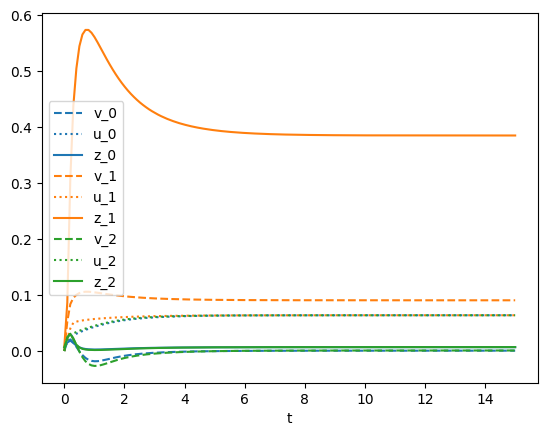

In [64]:
import matplotlib.colors as mcolors
COLORS = mcolors.TABLEAU_COLORS
COLORS = list(COLORS.values())

t = np.linspace(0, 15, 150)

v = np.array([0.0, 0.0, 0.0])
u = np.array([0.0, 0.0, 0.0])
I = np.array([0.2, 0.6, 0.3])

c = np.array([0.3, 0.3, 0.3])

params = {
    'N': 3,
    'tau': 1.0,
    'lambda': 100,
    'alpha': 5,
    'I': I,
    'rho': 0.8,
    'gamma': 0.05,
    'c': c, # need to make c a vector later on
    'beta': 50.0,
    'mu': 0.1
}

state = np.concatenate((v, u), axis=0)

result = solve_ivp(fun=lambda t, state: doodle(t, state, params), t_span=(0,200), t_eval=t, y0=state)
v_series = result.y[:3,]
z_series = transform(v_series, params['beta'], params['mu'])
u_series = result.y[3:,]

fig,ax = plt.subplots()
for i in range(params['N']):
    color = COLORS[i]
    ax.plot(t, v_series[i], label=f'v_{i}', c=color, linestyle='dashed')
    ax.plot(t, u_series[i], label=f'u_{i}', c=color, linestyle='dotted')
    ax.plot(t, z_series[i], label=f'z_{i}', c=color, linestyle='solid')

ax.legend()
# ax.set_ylim([0, 1])
ax.set_xlabel('t')
